## Equivariance Analysis of MFA Method for Undirected Graphs

### Introduction

In this notebook, we examine the $S_n$-equivariance of our MFA method on undirected weighted graphs. All network inputs and outputs are symmetric matrices with a shape of $n\times n$. We ensure the output is also an undirected weighted adjacency matrix by computing $f(x)f(x)^T$.

### $S_n$-Equivariance Test on Undirected Unweighted Graphs

  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\kruskallin\Desktop\Miscellaneous\research\MFA\tests\model.py:55: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(self.fc1.weight)
100%|██████████| 100/100 [00:06<00:00, 14.67it/s]


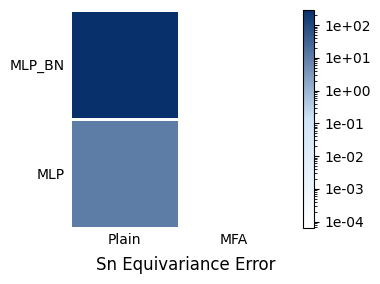

In [2]:
import torch
import numpy as np
from tqdm import tqdm
from model import MLP_S, MLP_S_BN_Mish
from minimal_frame.graph_group_decorator import undirected_unweighted_sn_equivariant_decorator
from visualize import visualize
import networkx as nx

n = 128
trials = 100

def equivariance_error_left_right_multiply(f, pc, transform):
    source = f(pc)
    target = f(transform @ pc @ transform.T)
    err = (target @ target.T - transform @ source @ source.T @ transform.T).abs().sum(-1)
    return err.mean()


def compute_equivariance_error(model, pc, n, group_decorator, transform):
    m = model(n, n)
    origin = equivariance_error_left_right_multiply(m, pc, transform)
    
    f = model(n, n)
    f.forward = group_decorator(f.forward)
    frame = equivariance_error_left_right_multiply(f, pc, transform)
    return origin, frame


def generate_Sn_matrix(n):
    I = np.eye(n)
    p = np.random.permutation(n)
    P = I[p]
    return torch.FloatTensor(P)


def sn_equivariance_error(decorator):
    errors_MLP = []
    errors_MLP_BN = []

    for _ in tqdm(range(trials)):
        G = nx.erdos_renyi_graph(n, 0.5)
        adjacency_matrix = nx.adjacency_matrix(G).todense()
        pc = torch.FloatTensor(np.array(adjacency_matrix))
        transform = generate_Sn_matrix(n)
        error_MLP = compute_equivariance_error(MLP_S, pc, n, decorator, transform=transform)
        errors_MLP.append(error_MLP)

        error_MLP_BN = compute_equivariance_error(MLP_S_BN_Mish, pc, n, decorator, transform=transform)
        errors_MLP_BN.append(error_MLP_BN)

    errors_MLP = torch.FloatTensor(errors_MLP).mean(0).numpy()
    errors_MLP_BN = torch.FloatTensor(errors_MLP_BN).mean(0).numpy()
    errors = np.stack([errors_MLP, errors_MLP_BN], axis=0)
    return errors

errors = sn_equivariance_error(undirected_unweighted_sn_equivariant_decorator)
# Error is very close to 0; Add 1e-10 to error to adjust the number scale.
visualize(errors + 1e-10, figsize=(4, 3), x_labels=['Plain', 'MFA'], y_labels=['MLP', 'MLP_BN'], title='Sn Equivariance Error', color='blue')

### $S_n$-Equivariance Test on Undirected Weighted Graphs

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\kruskallin\Desktop\Miscellaneous\research\MFA\tests\model.py:55: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(self.fc1.weight)
100%|██████████| 100/100 [03:11<00:00,  1.92s/it]


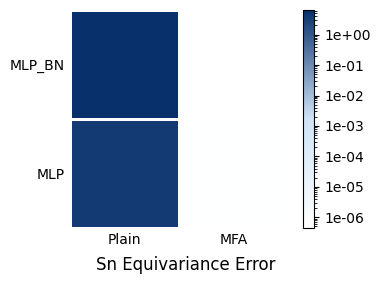

In [1]:
import torch
import numpy as np
from tqdm import tqdm
from model import MLP_S, MLP_S_BN_Mish
from minimal_frame.graph_group_decorator import undirected_weighted_sn_equivariant_decorator
from visualize import visualize

n = 16
trials = 100

def equivariance_error_left_right_multiply(f, pc, transform):
    source = f(pc)
    target = f(transform @ pc @ transform.T)
    err = (target @ target.T - transform @ source @ source.T @ transform.T).abs().sum(-1)
    return err.mean()


def compute_equivariance_error(model, pc, n, group_decorator, transform):
    m = model(n, n)
    origin = equivariance_error_left_right_multiply(m, pc, transform)
    
    f = model(n, n)
    f.forward = group_decorator(f.forward)
    frame = equivariance_error_left_right_multiply(f, pc, transform)
    return origin, frame


def generate_Sn_matrix(n):
    I = np.eye(n)
    p = np.random.permutation(n)
    P = I[p]
    return torch.FloatTensor(P)


def sn_equivariance_error(decorator):
    errors_MLP = []
    errors_MLP_BN = []

    for _ in tqdm(range(trials)):
        pc = torch.randn((n, n))
        pc = pc @ pc.T
        transform = generate_Sn_matrix(n)
        error_MLP = compute_equivariance_error(MLP_S, pc, n, decorator, transform=transform)
        errors_MLP.append(error_MLP)

        error_MLP_BN = compute_equivariance_error(MLP_S_BN_Mish, pc, n, decorator, transform=transform)
        errors_MLP_BN.append(error_MLP_BN)

    errors_MLP = torch.FloatTensor(errors_MLP).mean(0).numpy()
    errors_MLP_BN = torch.FloatTensor(errors_MLP_BN).mean(0).numpy()
    errors = np.stack([errors_MLP, errors_MLP_BN], axis=0)
    return errors

errors = sn_equivariance_error(undirected_weighted_sn_equivariant_decorator)
# Error is very close to 0; Add 1e-10 to error to adjust the number scale.
visualize(errors + 1e-10, figsize=(4, 3), x_labels=['Plain', 'MFA'], y_labels=['MLP', 'MLP_BN'], title='Sn Equivariance Error', color='blue')